#Visualization of CNN network for cat Recognizer
##Name- Swastik Mahapatra       Email:-swastik.mhptr@gmail.com

The Model here is made from scratch Python , with only numpy used for vectorization and broadcasting.
The Convolutional Neural Network has 2 Convolutional Layers which are RELU activated and then are followed by Max-Pooling

##  Packages Used

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.


In [0]:
import numpy as np                   # For vectorization and quick matrix operations
import math                          #for permutation function in 
import matplotlib.pyplot as plt      #to plot the training cost curve
import h5py                          #to extract the images from the .h5 type file
import cv2                           #OPENCV to Preprocess the images
from matplotlib import pyplot as plt #to plot the images and the matrices of convolutional layers

%matplotlib inline

Setting up the directory for Train and test data

In [0]:
train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
test_dataset = h5py.File('data/test_catvnoncat.h5', "r")

Extrading train and test data from the .h5py files

In [0]:
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #initialising i/o of train datasets
train_set_y = np.array(train_dataset["train_set_y"][:])
train_set_y = train_set_y.reshape((1,train_set_y.shape[0]))

test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #initialising i/o of test datasets
test_set_y = np.array(test_dataset["test_set_y"][:])
test_set_y = test_set_y.reshape((1,test_set_y.shape[0]))

classes = np.array(test_dataset["list_classes"][:])

In [10]:
print(train_set_y.shape)

(1, 209)


y = [1], it's a 'cat' picture.


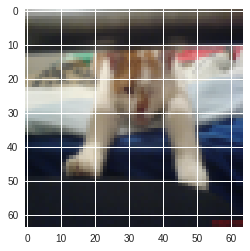

In [11]:
# Example of a not cat picture
index = 29
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Flattening the data to be fed into minibatches creater function

In [12]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1)

print(train_set_x_flatten.shape)
print(test_set_x_flatten.shape)

(209, 12288)
(50, 12288)


#Activation Functions

In [0]:
def relu(z):
    
    s = np.maximum(0,z)
    
    return s

In [0]:
def reluderivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [0]:
def softmax(x):
    e_x = np.exp(x)
    return np.exp(x) / np.sum(e_x,axis=0)

In [0]:
def relu_forward(X):
    out = np.maximum(X, 0)
    return out

In [0]:
def relu_backward(dout, cache):
    dX = dout.copy()
    dX[cache <= 0] = 0
    return dX

In [0]:
def sigmoid(z):
   
    s = 1 / (1 + np.exp(-z))
    
    return s

Functions to convert numpy arrays from matrix to image form and from image to matrix form, for convolutional layer calculations

In [0]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    N, C, H, W = x_shape
    assert (H + 2 * padding - field_height) % stride == 0
    assert (W + 2 * padding - field_height) % stride == 0
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k.astype(int), i.astype(int), j.astype(int))


def im2col_indices(x, field_height, field_width, padding=1, stride=1):    
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                   stride=1):
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0:
        return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

Initialising Weights and Bias

In [0]:
def initialize(layer):
    
    l = len(layer)
    parameters = {}
    #np.random.seed(9)
    #defines number of filters in each layer
    D=[3,16,16] #shows there are 16 filters for both 1st and 2nd convolutionnal layers
    #defines filter size for each layer
    F=[0,5,5] # Shows the filter size to be 5X5 for both layers
    u = len(D)
    #for convolutional layers
    for j in range(1,3):
      parameters["Wc"+str(j)]=np.random.randn(D[j], D[j-1], F[j], F[j]) / np.sqrt(D[j] / 2.)
      parameters["bc"+str(j)]=np.zeros((D[j], 1))
    #for fully connected layer  
    for i in range(1,l-1):
      parameters["W"+str(i)]=np.random.randn(layer[i],layer[i-1]) * np.sqrt(2/layer[i-1]) 
      parameters["b"+str(i)]=np.zeros((layer[i],1))
    
    parameters["W"+str(l-1)]=np.random.randn(layer[l-1],layer[l-2]) * 0.001
    parameters["b"+str(l-1)]=np.zeros((layer[l-1],1)) 
   
    
    return parameters

Initialising parameters for ADAM optimisation

In [0]:
def initialize_adam(parameters,layer) :
    
    L = (len(parameters)-4) // 2
    v = {}
    s = {}
    #Initialising parameters for Adams optimization
    #for convolutional layers
    for i in range(2):
      v["dwc" + str(i+1)] = np.zeros(parameters['Wc' + str(i+1)].shape)
      v["dbc" + str(i+1)] = np.zeros(parameters['bc' + str(i+1)].shape)
      s["dwc" + str(i+1)] = np.zeros(parameters['Wc' + str(i+1)].shape)
      s["dbc" + str(i+1)] = np.zeros(parameters['bc' + str(i+1)].shape)
   #For fully connected layers
    for l in range(L-1):
      v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
      v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
      s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
      s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    
    return v, s

Function to create Random mini Batches

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 512):
    
               
    m = X.shape[0]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[:,permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*mini_batch_size : (k+1)*mini_batch_size,:]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size : (k+1)*mini_batch_size]
      
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[num_complete_minibatches*mini_batch_size:,:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Function for Forward Propagation through one Convolutional Layer

In [0]:
def conv_forward(X, W, b, stride=1, padding=1):
    cache = W, b, stride, padding
    n_filters, d_filter, h_filter, w_filter = W.shape
    n_x, d_x, h_x, w_x = X.shape
    h_out = (h_x - h_filter + 2 * padding) / stride + 1
    w_out = (w_x - w_filter + 2 * padding) / stride + 1

    h_out, w_out = int(h_out), int(w_out)

    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    W_col = W.reshape(n_filters, -1)

    out = W_col @ X_col + b
    out = out.reshape(n_filters, h_out, w_out, n_x)
    out = out.transpose(3, 0, 1, 2)

    cache = (X, W, b, stride, padding, X_col)

    return out, cache

Function for BackPropagation through one convolutional Layer

In [0]:
def conv_backward(dout, cache):
    X, W, b, stride, padding, X_col = cache
    n_filter, d_filter, h_filter, w_filter = W.shape

    db = np.sum(dout, axis=(0, 2, 3))
    db = db.reshape(n_filter, -1)

    dout_reshaped = dout.transpose(1, 2, 3, 0).reshape(n_filter, -1)
    dW = dout_reshaped @ X_col.T
    dW = dW.reshape(W.shape)

    W_reshape = W.reshape(n_filter, -1)
    dX_col = W_reshape.T @ dout_reshaped
    dX = col2im_indices(dX_col, X.shape, h_filter, w_filter, padding=padding, stride=stride)

    return dX, dW, db


Function to forward propagate through one Pool Layer

In [0]:
def _pool_forward(X, pool_fun, size=2, stride=2):
    n, d, h, w = X.shape
    h_out = (h - size) / stride + 1
    w_out = (w - size) / stride + 1

    if not w_out.is_integer() or not h_out.is_integer():  #raise exception is the Pooling filters are not being able to cover the image properly
        raise Exception('Invalid output dimension!')

    h_out, w_out = int(h_out), int(w_out)

    X_reshaped = X.reshape(n * d, 1, h, w)
    X_col = im2col_indices(X_reshaped, size, size, padding=0, stride=stride)

    out, pool_cache = pool_fun(X_col)

    out = out.reshape(h_out, w_out, n, d)
    out = out.transpose(2, 3, 0, 1)

    cache = (X, size, stride, X_col, pool_cache)

    return out, cache

Function to back propagate through one Pool Layer

In [0]:
def _pool_backward(dout, dpool_fun, cache):
    X, size, stride, X_col, pool_cache = cache
    n, d, w, h = X.shape

    dX_col = np.zeros_like(X_col)
    dout_col = dout.transpose(2, 3, 0, 1).ravel()

    dX = dpool_fun(dX_col, dout_col, pool_cache)

    dX = col2im_indices(dX_col, (n * d, 1, h, w), size, size, padding=0, stride=stride)
    dX = dX.reshape(X.shape)

    return dX

Function for one max pooling layer

In [0]:
def maxpool_forward(X, size=2, stride=2):
    def maxpool(X_col):
        max_idx = np.argmax(X_col, axis=0)
        out = X_col[max_idx, range(max_idx.size)]
        return out, max_idx

    return _pool_forward(X, maxpool, size, stride)

Functuon for back propagation on max pooling 

In [0]:

def maxpool_backward(dout, cache):
    def dmaxpool(dX_col, dout_col, pool_cache):
        dX_col[pool_cache, range(dout_col.size)] = dout_col
        return dX_col

    return _pool_backward(dout, dmaxpool, cache)

Forward Propagation without Dropouts, used for testing

In [0]:
def fwd_propagation(X,parameters,layer):
  
  l = len(layer)
  forward = {}
  cache={}
  
  #for convolutional layer 1
  forward["Zc"+str(1)], cache["Zc"+str(1)] = conv_forward(X, parameters['Wc'+str(1)], parameters['bc'+str(1)],stride=1,padding=2)
  forward["Ac"+str(1)]= relu_forward(forward["Zc"+str(1)])
  forward["Pc"+str(1)], cache["Pc"+str(1)] = maxpool_forward(forward["Ac"+str(1)])
  
  #for convolutional layer 2    
  forward["Zc"+str(2)], cache["Zc"+str(2)] = conv_forward(forward["Pc"+str(1)], parameters['Wc'+str(2)], parameters['bc'+str(2)],stride=1,padding=2)
  forward["Ac"+str(2)]= relu_forward(forward["Zc"+str(2)])
  forward["Pc"+str(2)], cache["Pc"+str(2)] = maxpool_forward(forward["Ac"+str(2)])
  
  #for convolutional layer 3
  #forward["Zc"+str(3)], cache["Zc"+str(3)] = conv_forward(forward["Pc"+str(2)], parameters['Wc'+str(3)], parameters['bc'+str(3)],stride=1,padding=1)
  #forward["Ac"+str(3)]= relu_forward(forward["Zc"+str(3)])
  #forward["Pc"+str(3)], cache["Pc"+str(3)] = maxpool_forward(forward["Ac"+str(3)])
  
  #for convolutional layer 4
  #forward["Zc"+str(4)], cache["Zc"+str(4)] = conv_forward(forward["Pc"+str(3)], parameters['Wc'+str(4)], parameters['bc'+str(4)])
  #forward["Ac"+str(4)]= relu_forward(forward["Zc"+str(4)])
  #forward["Pc"+str(4)], cache["Pc"+str(4)] = maxpool_forward(forward["Ac"+str(4)],size=2,stride=2)
  
  #to flatten for fully connected layers
  h2 = forward["Pc"+str(2)].ravel().reshape(X.shape[0],-1)
  h2=np.transpose(h2)
  
  #for fully connected part
  forward["Z"+str(1)]=np.dot(parameters["W"+str(1)],h2)+parameters["b"+str(1)]
  forward["A"+str(1)]=relu(forward["Z"+str(1)])
  
  for i in range(2,l-1):
    forward["Z"+str(i)]=np.dot(parameters["W"+str(i)],forward["A"+str(i-1)])+parameters["b"+str(i)]
    forward["A"+str(i)]=relu(forward["Z"+str(i)])
   
  forward["Z"+str(l-1)]=np.dot(parameters["W"+str(l-1)],forward["A"+str(l-2)])+parameters["b"+str(l-1)]
  forward["A"+str(l-1)]=sigmoid(forward["Z"+str(l-1)])
  
  return forward,cache

Forward Propagation with dropouts for fully connected layers

In [0]:
def fwd_propagation_drop(X,parameters,layer,keep_prob):
  drop = {}
  l = len(layer)
  forward = {}
  cache={}
  
  #for convolutional layer1
  forward["Zc"+str(1)], cache["Zc"+str(1)] = conv_forward(X, parameters['Wc'+str(1)], parameters['bc'+str(1)],stride=1,padding=2)
  forward["Ac"+str(1)]= relu_forward(forward["Zc"+str(1)])
  forward["Pc"+str(1)], cache["Pc"+str(1)] = maxpool_forward(forward["Ac"+str(1)])
  
  #for convolutional layer 2    
  forward["Zc"+str(2)], cache["Zc"+str(2)] = conv_forward(forward["Pc"+str(1)], parameters['Wc'+str(2)], parameters['bc'+str(2)],stride=1,padding=2)
  forward["Ac"+str(2)]= relu_forward(forward["Zc"+str(2)])
  forward["Pc"+str(2)], cache["Pc"+str(2)] = maxpool_forward(forward["Ac"+str(2)])
  
  #for convolutional layer 3
  #forward["Zc"+str(3)], cache["Zc"+str(3)] = conv_forward(forward["Pc"+str(2)], parameters['Wc'+str(3)], parameters['bc'+str(3)],stride=1,padding=1)
  #forward["Ac"+str(3)]= relu_forward(forward["Zc"+str(3)])
  #forward["Pc"+str(3)], cache["Pc"+str(3)] = maxpool_forward(forward["Ac"+str(3)])
  
  #for convolutional layer 4
  #forward["Zc"+str(4)], cache["Zc"+str(4)] = conv_forward(forward["Pc"+str(3)], parameters['Wc'+str(4)], parameters['bc'+str(4)])
  #forward["Ac"+str(4)]= relu_forward(forward["Zc"+str(4)])
  #forward["Pc"+str(4)], cache["Pc"+str(4)] = maxpool_forward(forward["Ac"+str(4)],size=2,stride=2)
  
  #to flatten for fully connected layers
  h2 = forward["Pc"+str(2)].ravel().reshape(X.shape[0], -1)
  h2=np.transpose(h2)
  
  #for fully connected part with dropouts
  forward["Z"+str(1)]=np.dot(parameters["W"+str(1)],h2)+parameters["b"+str(1)]  
  forward["A"+str(1)]=relu(forward["Z"+str(1)])
  #dropout
  drop["d"+str(1)]=(np.random.rand(forward["A"+str(1)].shape[0],forward["A"+str(1)].shape[1])) < keep_prob[1]
  forward["A"+str(1)] = np.multiply(forward["A"+str(1)],drop["d"+str(1)])
  forward["A"+str(1)] = forward["A"+str(1)] / keep_prob[1]
  
  for i in range(2,l-1):
    forward["Z"+str(i)]=np.dot(parameters["W"+str(i)],forward["A"+str(i-1)])+parameters["b"+str(i)]
    
    forward["A"+str(i)]=relu(forward["Z"+str(i)])
    drop["d"+str(i)]=(np.random.rand(forward["A"+str(i)].shape[0],forward["A"+str(i)].shape[1])) < keep_prob[i]
    
    forward["A"+str(i)] = np.multiply(forward["A"+str(i)],drop["d"+str(i)])
    forward["A"+str(i)] = forward["A"+str(i)] / keep_prob[i]
    
 
  forward["Z"+str(l-1)]=np.dot(parameters["W"+str(l-1)],forward["A"+str(l-2)])+parameters["b"+str(l-1)]
  forward["A"+str(l-1)]=sigmoid(forward["Z"+str(l-1)])
  
  return forward,cache

Back Propagation through the network while using L2 regularization for fully connected layers

In [0]:
def back_prop(X,Y,forward,cache,layer,parameters,lambd=0.6):
  m = X.shape[1]
  l = len(layer)
  grads = {}
  
  grads["dz"+str(l-1)]= forward["A"+str(l-1)] - Y
  grads["dw"+str(l-1)]=(np.dot(grads["dz"+str(l-1)],forward["A"+str(l-2)].T) / m) + ((lambd/m)*parameters["W"+str(l-1)])
  grads["db"+str(l-1)]=np.sum(grads["dz"+str(l-1)],axis=1,keepdims=True) / m 
  grads["da"+str(l-2)]=np.dot(parameters["W"+str(l-1)].T,grads["dz"+str(l-1)])
  
  for i in range(l-2,1,-1):
    grads["dz"+str(i)]=grads["da"+str(i)]*reluderivative(forward["A"+str(i)])
    grads["dw"+str(i)]=(np.dot(grads["dz"+str(i)],forward["A"+str(i-1)].T) / m) + ((lambd/m)*parameters["W"+str(i)])
    grads["db"+str(i)]=np.sum(grads["dz"+str(i)],axis=1,keepdims=True)/m
    grads["da"+str(i-1)]=np.dot(parameters["W"+str(i)].T,grads["dz"+str(i)])
  
  grads["dz"+str(1)]=grads["da"+str(1)]*reluderivative(forward["A"+str(1)])
  h8 = forward["Pc"+str(2)].ravel().reshape(X.shape[0], -1)
  h8=np.transpose(h8)
  grads["dw"+str(1)]=np.dot(grads["dz"+str(1)],h8.T)/m + ((lambd/m)*parameters["W"+str(1)])

  grads["db"+str(1)]=np.sum(grads["dz"+str(1)],axis=1,keepdims=True)/m
  grads["da"+str(0)]=np.dot(parameters["W"+str(1)].T,grads["dz"+str(1)])
  
  #conversion to enter convolutional layers
  cnv = grads["da"+str(0)].ravel().reshape(forward["Pc"+str(2)].shape)
  
  
  #convolutional Layer 4
  #grads["dp"+str(4)] = maxpool_backward(cnv, cache["Pc"+str(4)])
  #grads["dzc"+str(4)] = relu_backward(grads["dp"+str(4)], forward["Zc"+str(4)])
  #grads["dac"+str(3)], grads["dwc"+str(4)], grads["dbc"+str(4)] = conv_backward(grads["dzc"+str(4)], cache["Zc"+str(4)])
  
  #for convolutional Layer 3
  #grads["dp"+str(3)] = maxpool_backward(grads["dac"+str(3)], cache["Pc"+str(3)])
  #grads["dzc"+str(3)] = relu_backward(grads["dp"+str(3)], forward["Zc"+str(3)])
  #grads["dac"+str(2)], grads["dwc"+str(3)], grads["dbc"+str(3)] = conv_backward(grads["dzc"+str(3)], cache["Zc"+str(3)])
  
  #for convolutional layer 2
  grads["dp"+str(2)] = maxpool_backward(cnv, cache["Pc"+str(2)])
  grads["dzc"+str(2)] = relu_backward(grads["dp"+str(2)], forward["Zc"+str(2)])
  grads["dac"+str(1)], grads["dwc"+str(2)], grads["dbc"+str(2)] = conv_backward(grads["dzc"+str(2)], cache["Zc"+str(2)])
  
  #for convolutional layer 1   
  grads["dp"+str(1)] = maxpool_backward(grads["dac"+str(1)], cache["Pc"+str(1)])
  grads["dzc"+str(1)] = relu_backward(grads["dp"+str(1)], forward["Zc"+str(1)])
  grads["dac"+str(0)], grads["dwc"+str(1)], grads["dbc"+str(1)] = conv_backward(grads["dzc"+str(1)], cache["Zc"+str(1)])

    
  return grads

Updation of parameters using ADAM's Optimization

In [0]:
def update_parameters_with_adam(parameters, grads, layer, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    
    L = (len(parameters)-4) //2              # number of layers in the neural networks (-4 is done to not consider parameters of convolutional layers)
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    #For the parameters of convolutional layers
    for j in range(1,3):
      v["dwc" + str(j)] = beta1 * v['dwc' + str(j)] + (1-beta1) * grads['dwc' + str(j)]
      v["dbc" + str(j)] = beta1 * v['dbc' + str(j)] + (1-beta1) * grads['dbc' + str(j)]
       
      v_corrected["dwc" + str(j)] = v['dwc' + str(j)] / (1 - np.power(beta1, t))
      v_corrected["dbc" + str(j)] = v['dbc' + str(j)] / (1 - np.power(beta1, t))
       
      s["dwc" + str(j)] = beta2 * s['dwc' + str(j)] + (1-beta2) * np.power(grads['dwc' + str(j)], 2)
      s["dbc" + str(j)] = beta2 * s['dbc' + str(j)] + (1-beta2) * np.power(grads['dbc' + str(j)], 2)
        
      s_corrected["dwc" + str(j)] = s['dwc' + str(j)] / (1 - np.power(beta2, t))
      s_corrected["dbc" + str(j)] = s['dbc' + str(j)] / (1 - np.power(beta2, t))
       
      parameters["Wc" + str(j)] = parameters['Wc' + str(j)] - learning_rate * v_corrected['dwc' + str(j)] / np.sqrt(s_corrected['dwc' + str(j)] + epsilon)
      parameters["bc" + str(j)] = parameters['bc' + str(j)] - learning_rate * v_corrected['dbc' + str(j)] / np.sqrt(s_corrected['dbc' + str(j)] + epsilon)
    
    #for the parameters of fully connected layers
    for l in range(L-1):
       
        v["dW" + str(l+1)] = beta1 * v['dW' + str(l+1)] + (1-beta1) * grads['dw' + str(l+1)]
        v["db" + str(l+1)] = beta1 * v['db' + str(l+1)] + (1-beta1) * grads['db' + str(l+1)]
       
        v_corrected["dw" + str(l+1)] = v['dW' + str(l+1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l+1)] = v['db' + str(l+1)] / (1 - np.power(beta1, t))
       

        s["dW" + str(l+1)] = beta2 * s['dW' + str(l+1)] + (1-beta2) * np.power(grads['dw' + str(l+1)], 2)
        s["db" + str(l+1)] = beta2 * s['db' + str(l+1)] + (1-beta2) * np.power(grads['db' + str(l+1)], 2)
        
        s_corrected["dw" + str(l+1)] = s['dW' + str(l+1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l+1)] = s['db' + str(l+1)] / (1 - np.power(beta2, t))
       
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * v_corrected['dw' + str(l+1)] / np.sqrt(s_corrected['dw' + str(l+1)] + epsilon)
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * v_corrected['db' + str(l+1)] / np.sqrt(s_corrected['db' + str(l+1)] + epsilon)
       
    return parameters, v, s

Prediction function used to predict for validation and test set

In [0]:
def predict(X,parameters,layers,h=0):
  l= len(layer)
  fwd,cache = fwd_propagation(X,parameters,layers)
  
  Y2 = fwd["A"+str(l-1)]
  
  if h==1:
    return Y2,fwd
  return Y2

Function to calculate Cost after each Epoc

In [0]:
def calculate_cost(Y,forward,parameters,layer,lambd=0.6):
  l= len(layer)
  m=Y.shape[1]
  
  cost = (-1 * np.sum((Y * np.log(forward["A"+str(l-1)])) + (1 - Y) * np.log(1 - forward["A"+str(l-1)])) / m) + ((lambd/(2*m))*np.sum(np.square(parameters["W"+str(l-1)])))
  
  return cost

Final Model to bring all functions together

In [0]:
def model(X_train,Y_train, X_test, Y_test, layer, keep_prob,mini_batch_size=512, beta1=0.0, beta2=0.0, learning_rate=0.001, iterations = 1500, lambd=0.6):
  costs = []
  
  parameters = initialize(layer)
  v, s = initialize_adam(parameters,layer)
  t = 0
  
  for j in range(iterations):
  
    minibatches = random_mini_batches(X_train,Y_train,mini_batch_size)  #Splitting the Training set into multiple minibatches
    
    for minibatch in minibatches:
      (minibatch_x,minibatch_y) = minibatch
      
      minibatch_x = np.asarray(minibatch_x).reshape((-1, 64, 64, 3)) #Reshaping minibatch to be fed into convolutional Layers
      minibatch_x=minibatch_x.transpose(0,3,1,2)
      
      forward,cache = fwd_propagation_drop(minibatch_x,parameters,layer,keep_prob)  # For one forward propagation of the minibatch through all layers
     
      cost = calculate_cost(minibatch_y,forward,parameters,layer,lambd)  # To calculate cost for each Minibatch
      
      grads = back_prop(minibatch_x,minibatch_y,forward,cache,layer,parameters,lambd) #To Back-Propagate through all the layers and calculate Gradient
      
      t=t+1   #FOr ADAM's Optimization
      
      parameters,v,s = update_parameters_with_adam(parameters, grads, layer, v, s, t, learning_rate,beta1, beta2) #Updating Parameters using ADAM's Optimization
    
    
    if j % 5 == 0:
      costs.append(cost)
    
    if j%20 == 0:
      print ("Cost after iteration %i: %f" %(j , cost))
  train = np.asarray(X_train).reshape((-1, 64, 64, 3))
  train=train.transpose(0,3,1,2)    
  Y_prediction_train = predict(train,parameters,layer)
  Y_prediction_test = predict(X_test,parameters,layer)

  
  return parameters, grads, forward, costs, Y_prediction_test, Y_prediction_train

#Preprocessing the images and feeding for training

In [0]:
#Normalising the Test and Train Sets

train_set_x_flatten = train_set_x_flatten/255
test_set_x_flatten = test_set_x_flatten/255

In [39]:
#Reshaping test set
X_train=train_set_x_flatten
X_test = np.asarray(test_set_x_flatten).reshape((-1, 64, 64, 3))
X_test=X_test.transpose(0,3,1,2)
print(X_test.shape)

(50, 3, 64, 64)


In [40]:
print(X_train.shape)
print(X_test.shape)

(209, 12288)
(50, 3, 64, 64)


In [0]:
Y_train=train_set_y
Y_test=test_set_y

In [42]:
layer = [4096,64,1]
keep_prob = [1.0,1.0,1.0]
para,grd,ford,cst,test,train1 = model(X_train, Y_train, X_test, Y_test, layer, keep_prob, mini_batch_size=128, beta1=0, beta2=0, learning_rate = 0.001, iterations = 500, lambd = 0.0 ) 

Cost after iteration 0: 0.629557
Cost after iteration 20: 0.636056
Cost after iteration 40: 0.604606
Cost after iteration 60: 0.580877
Cost after iteration 80: 0.539807
Cost after iteration 100: 0.603590
Cost after iteration 120: 0.539502
Cost after iteration 140: 0.454250
Cost after iteration 160: 0.498627
Cost after iteration 180: 0.448410
Cost after iteration 200: 0.495122
Cost after iteration 220: 0.436851
Cost after iteration 240: 0.465236
Cost after iteration 260: 0.421066
Cost after iteration 280: 0.432385
Cost after iteration 300: 0.335178
Cost after iteration 320: 0.377707
Cost after iteration 340: 0.437796
Cost after iteration 360: 0.466552
Cost after iteration 380: 0.421422
Cost after iteration 400: 0.446298
Cost after iteration 420: 0.433351
Cost after iteration 440: 0.449934
Cost after iteration 460: 0.493896
Cost after iteration 480: 0.468445


In [44]:
tr=np.around(train1)
te=np.around(test)
tr_Accuracy=np.mean(tr==Y_train)*100
te_Accuracy=np.mean(te==Y_test)*100
print("The Training Accuracy is "+str(tr_Accuracy)+"%")
print("The Testing Accuracy is "+str(te_Accuracy)+"%")

The Training Accuracy is 83.25358851674642%
The Testing Accuracy is 38.0%


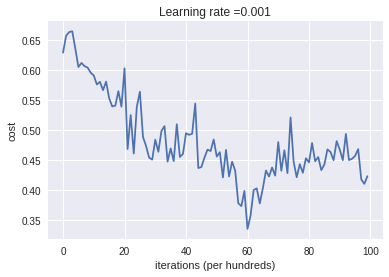

In [45]:
 costs  = np.squeeze(cst)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(0.001))
plt.show()

#Forward Propagating through one test image to visualize the convolutional layers

In [0]:
p,fwd1=predict(X_test[6:7],para,layer,h=1)

In [158]:
print("the prediction value is"+str(np.around(p)))

the prediction value is[[1.]]


y = [0], it's a 'non-cat' picture.


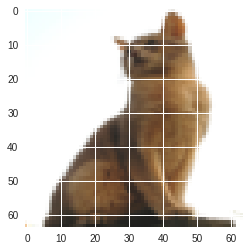

In [159]:
index = 6
plt.imshow(test_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

#The plots for different convolutional layers are

1) This is the Result post the 1st convolutional layer and before the RELU activation

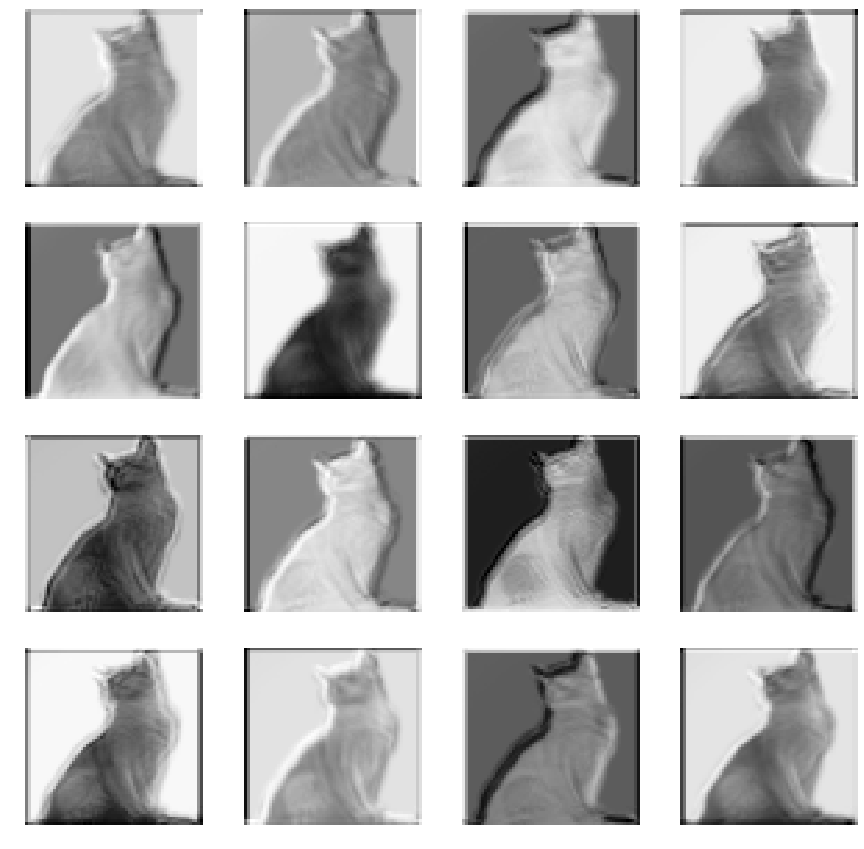

In [160]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(fwd1["Zc"+str(1)][0,i-1,:,:]),plt.axis("off")
plt.show()

2) This is th eoutput of first convolutional layer after RELU activation

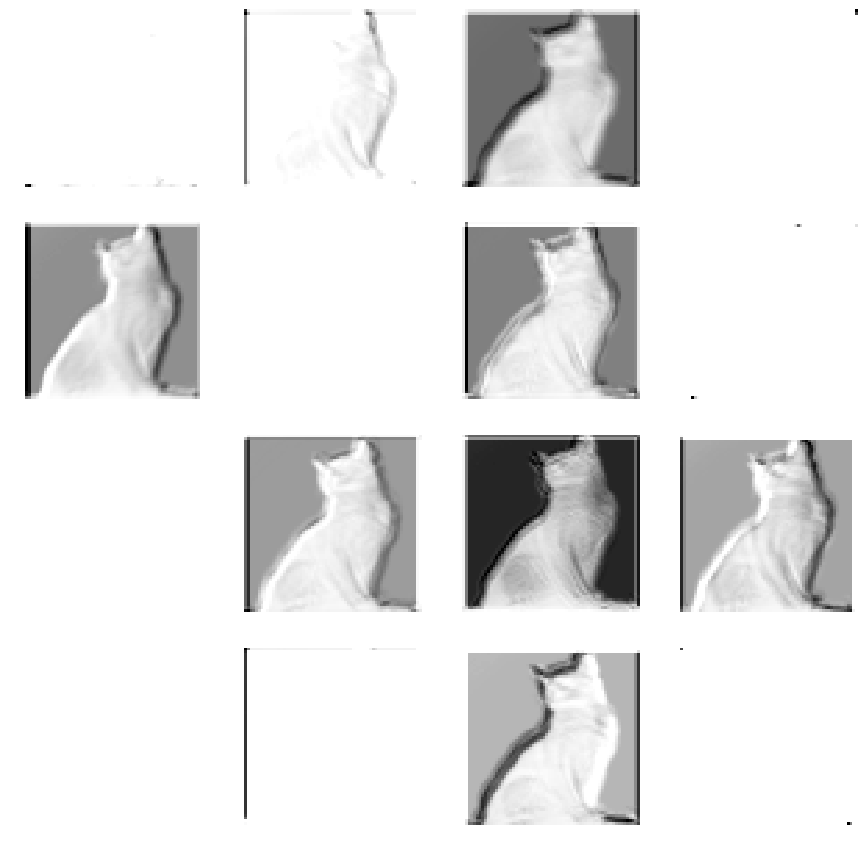

In [161]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(fwd1["Ac"+str(1)][0,i-1,:,:]),plt.axis("off")
plt.show()

3)This is the output after the first max pooling layer. Now the image size has reduced from 64X64 to 32X32

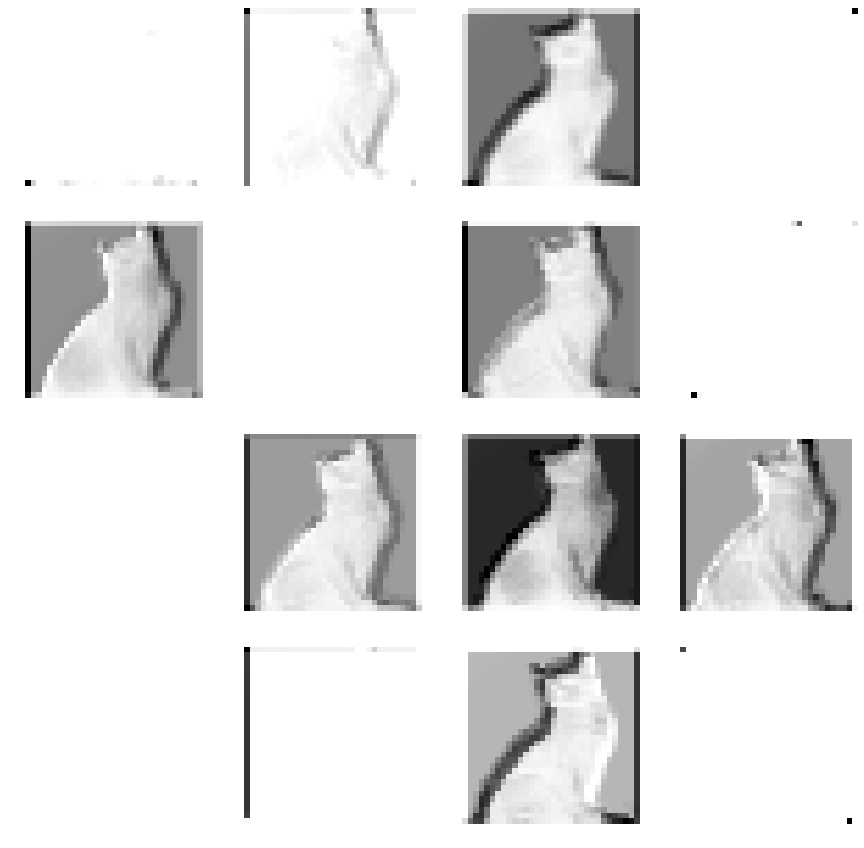

In [162]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(fwd1["Pc"+str(1)][0,i-1,:,:]),plt.axis("off")
plt.show()

4) Now this is the output after 2nd convolutional layer and before activation

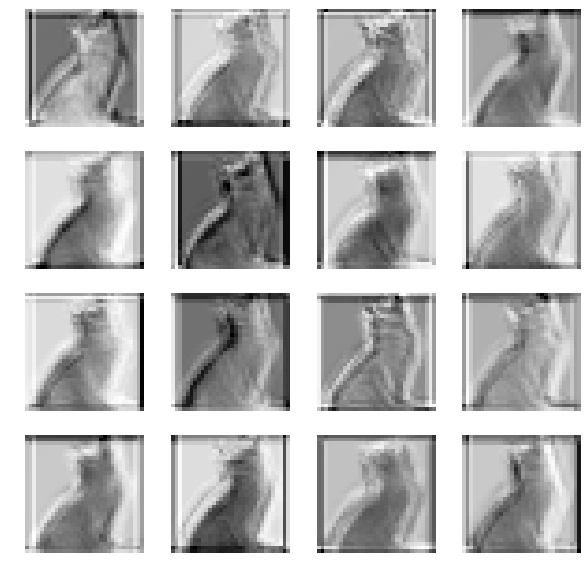

In [163]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(fwd1["Zc"+str(2)][0,i-1,:,:]),plt.axis("off")
plt.show()

5) This is the output for the 2nd convolutional layer after RELU activation

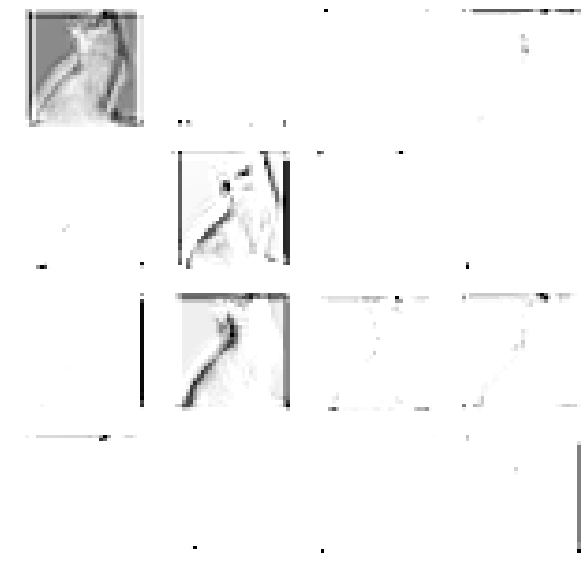

In [164]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(fwd1["Ac"+str(2)][0,i-1,:,:]),plt.axis("off")
plt.show()

6) Finally below is the output of the 2nd Max-Pooling Layer. Now the image dimentions has reduced from 32X32 to 16X16

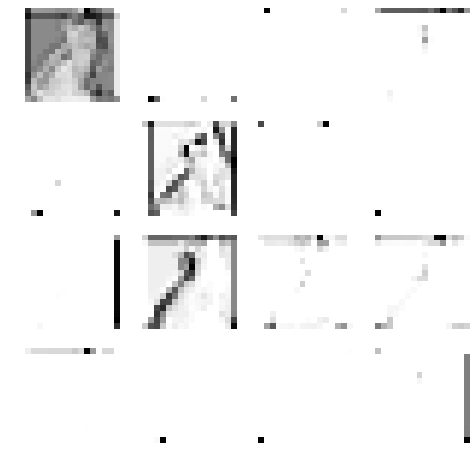

In [165]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(fwd1["Pc"+str(2)][0,i-1,:,:]),plt.axis("off")
plt.show()

##  ....END....